In [1]:
! pip install pyspark

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Regressão com Spark") \
    .getOrCreate()

spark

your 131072x1 screen size is bogus. expect trouble
25/01/27 21:45:57 WARN Utils: Your hostname, AnselmoHome resolves to a loopback address: 127.0.1.1; using 172.17.64.178 instead (on interface eth0)
25/01/27 21:45:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/27 21:46:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
caminho = '../data/imoveis.json'
dados = spark.read.json(
    caminho,
    multiLine=False
)

In [5]:
dados.show(truncate=False)

+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ident                     |listing                                                                                                                                                          |
+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{775564-BOJSMVON, Website}|{{Rio de Janeiro, {-22.909429, -43.413557}, Taquara, Zona Oeste}, {0, 0, 0, 1, 0, 62, 0, 0, 62}, {45000, {150, 0}}, {Outros, Residencial}}                       |
|{660895-AUENKNYY, Website}|{{Rio de Janeiro, {-22.869698, -43.509141}, Santíssimo, Zona Oeste}, {1, 2, 0, 1, 0, 0, 0, 0, 44}, {45000, {120, 0}}, {Apartamento, Residencial}}                |
|{751522-JESYFEQL, Website}|{{Rio de Janeiro,

In [6]:
dados.count()

73615

In [7]:
dados.printSchema()

root
 |-- ident: struct (nullable = true)
 |    |-- customerID: string (nullable = true)
 |    |-- source: string (nullable = true)
 |-- listing: struct (nullable = true)
 |    |-- address: struct (nullable = true)
 |    |    |-- city: string (nullable = true)
 |    |    |-- location: struct (nullable = true)
 |    |    |    |-- lat: double (nullable = true)
 |    |    |    |-- lon: double (nullable = true)
 |    |    |-- neighborhood: string (nullable = true)
 |    |    |-- zone: string (nullable = true)
 |    |-- features: struct (nullable = true)
 |    |    |-- bathrooms: long (nullable = true)
 |    |    |-- bedrooms: long (nullable = true)
 |    |    |-- floors: long (nullable = true)
 |    |    |-- parkingSpaces: long (nullable = true)
 |    |    |-- suites: long (nullable = true)
 |    |    |-- totalAreas: string (nullable = true)
 |    |    |-- unitFloor: long (nullable = true)
 |    |    |-- unitsOnTheFloor: long (nullable = true)
 |    |    |-- usableAreas: string (nullable =

In [8]:
dados\
        .select('ident.CustomerID', 'listing.*')\
        .show(truncate=False)

+---------------+--------------------------------------------------------------------------------+-------------------------------+---------------------+--------------------------+
|CustomerID     |address                                                                         |features                       |prices               |types                     |
+---------------+--------------------------------------------------------------------------------+-------------------------------+---------------------+--------------------------+
|775564-BOJSMVON|{Rio de Janeiro, {-22.909429, -43.413557}, Taquara, Zona Oeste}                 |{0, 0, 0, 1, 0, 62, 0, 0, 62}  |{45000, {150, 0}}    |{Outros, Residencial}     |
|660895-AUENKNYY|{Rio de Janeiro, {-22.869698, -43.509141}, Santíssimo, Zona Oeste}              |{1, 2, 0, 1, 0, 0, 0, 0, 44}   |{45000, {120, 0}}    |{Apartamento, Residencial}|
|751522-JESYFEQL|{Rio de Janeiro, {-22.986927, -43.646786}, Pedra de Guaratiba, Zona Oeste}      |{0

In [9]:
(
    dados
    .select('ident.customerID',
            'listing.types.*',
            'listing.features.*', 
            'listing.address.*', 
            'listing.prices.price', 
            'listing.prices.tax.*')
    .show(truncate=False)
)

+---------------+-----------+-----------+---------+--------+------+-------------+------+----------+---------+---------------+-----------+--------------+------------------------+------------------------+------------+-----+-----+----+
|customerID     |unit       |usage      |bathrooms|bedrooms|floors|parkingSpaces|suites|totalAreas|unitFloor|unitsOnTheFloor|usableAreas|city          |location                |neighborhood            |zone        |price|condo|iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+----------+---------+---------------+-----------+--------------+------------------------+------------------------+------------+-----+-----+----+
|775564-BOJSMVON|Outros     |Residencial|0        |0       |0     |1            |0     |62        |0        |0              |62         |Rio de Janeiro|{-22.909429, -43.413557}|Taquara                 |Zona Oeste  |45000|150  |0   |
|660895-AUENKNYY|Apartamento|Residencial|1        |2       |0     |1

In [10]:
(
    dados
    .select('ident.customerID',
            'listing.types.*',
            'listing.features.*', 
            'listing.address.*', 
            'listing.prices.price', 
            'listing.prices.tax.*')
    .drop('totalAreas'
          ,'location'
          ,'city'
          )
    .show(5,False)
)

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+----------+-----+-----+----+
|customerID     |unit       |usage      |bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood            |zone      |price|condo|iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+----------+-----+-----+----+
|775564-BOJSMVON|Outros     |Residencial|0        |0       |0     |1            |0     |0        |0              |62         |Taquara                 |Zona Oeste|45000|150  |0   |
|660895-AUENKNYY|Apartamento|Residencial|1        |2       |0     |1            |0     |0        |0              |44         |Santíssimo              |Zona Oeste|45000|120  |0   |
|751522-JESYFEQL|Outros     |Residencial|0        |0       |0     |0            |0     |0        |0 

In [11]:
dataset = (
    dados
        .select('ident.customerID',
                'listing.types.*',
                'listing.features.*', 
                'listing.address.*', 
                'listing.prices.price', 
                'listing.prices.tax.*')
        .drop('totalAreas'
             ,'location'
             ,'city'
            )

    )

In [12]:
dataset.show(5,False)

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+----------+-----+-----+----+
|customerID     |unit       |usage      |bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood            |zone      |price|condo|iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+----------+-----+-----+----+
|775564-BOJSMVON|Outros     |Residencial|0        |0       |0     |1            |0     |0        |0              |62         |Taquara                 |Zona Oeste|45000|150  |0   |
|660895-AUENKNYY|Apartamento|Residencial|1        |2       |0     |1            |0     |0        |0              |44         |Santíssimo              |Zona Oeste|45000|120  |0   |
|751522-JESYFEQL|Outros     |Residencial|0        |0       |0     |0            |0     |0        |0 

In [13]:
from pyspark.sql.types import IntegerType, DoubleType

In [14]:
dataset.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- usage: string (nullable = true)
 |-- bathrooms: long (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- floors: long (nullable = true)
 |-- parkingSpaces: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- unitFloor: long (nullable = true)
 |-- unitsOnTheFloor: long (nullable = true)
 |-- usableAreas: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- price: string (nullable = true)
 |-- condo: string (nullable = true)
 |-- iptu: string (nullable = true)



### Alterando campos da Dataset 

In [15]:

dataset = (
    dataset
        .withColumn('usableAreas', dataset['usableAreas'].cast(IntegerType()))
        .withColumn('price', dataset['price'].cast(DoubleType()))
        .withColumn('iptu', dataset['iptu'].cast(DoubleType()))
        .withColumn('condo', dataset['condo'].cast(DoubleType()))
        
)

In [16]:
(
    dataset
        .select('usage')
        .groupby('usage')
        .count()
        .show()
)

+-----------+-----+
|      usage|count|
+-----------+-----+
|  Comercial| 4019|
|Residencial|69596|
+-----------+-----+



In [31]:
dataset = (
    dataset
    .select('*')
    .where('usage == "Residencial"')
)

In [32]:
(
    dataset
        .select('unit')
        .groupby('unit')
        .count()
        .show()
)

+-----------+-----+
|       unit|count|
+-----------+-----+
|     Outros| 1186|
|Apartamento|58980|
|       Casa| 9273|
+-----------+-----+



In [30]:
(
    dataset
        .select('zone')
        .groupby('zone')
        .count()
        .show()
)

+------------+-----+
|        zone|count|
+------------+-----+
|  Zona Norte|14379|
|  Zona Oeste|35523|
|Zona Central| 1002|
|    Zona Sul|18535|
+------------+-----+



#### Tratamento de Dados faltantes

In [20]:
from pyspark.sql import functions as F

In [21]:
dataset.show(5,False)

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+----------+-------+-----+-----+
|customerID     |unit       |usage      |bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood            |zone      |price  |condo|iptu |
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+----------+-------+-----+-----+
|775564-BOJSMVON|Outros     |Residencial|0        |0       |0     |1            |0     |0        |0              |62         |Taquara                 |Zona Oeste|45000.0|150.0|0.0  |
|660895-AUENKNYY|Apartamento|Residencial|1        |2       |0     |1            |0     |0        |0              |44         |Santíssimo              |Zona Oeste|45000.0|120.0|0.0  |
|751522-JESYFEQL|Outros     |Residencial|0        |0       |0     |0            |0   

In [22]:

(
    dataset
        # Seleciona uma lista de expressões para calcular contagens de valores ausentes por coluna
        .select([
            # Para cada coluna 'c' em dataset.columns:
            F.count(
                # Conta as ocorrências onde o valor é NaN (not a number) ou nulo
                F.when(F.isnan(c) | F.isnull(c), True)
            ).alias(c)  # Nomeia o resultado da contagem com o nome da coluna original
            for c in dataset.columns
        ])
        # Exibe o resultado no console
        .show()
)

+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|customerID|unit|usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood|zone|price|condo|iptu|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|         0|   0|    0|        0|       0|     0|            0|     0|        0|              0|          0|           0|   0|    0| 6061|8726|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+



In [23]:
(
    
    dataset
        # Seleciona todas as colunas do DataFrame
        .select('*')
        # Lida com valores nulos (NA): substitui valores nulos por 0 em todas as colunas
        .na 
        .fill(0)
        # Exibe os resultados do DataFrame após as transformações
        .show()
)

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  price|condo| iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|  0.0|
|660895-AUENKNYY|Apartamento|Residencial|        1|       2|     0|            1|     0|        0|              0|         44|          Santíssimo|  Zona Oeste|45000.0|120.0|  0.0|
|751522-JESYFEQL|     Outros|Residencial|        0|       0|     0|            0|     0|       

In [24]:
dataset = (
    dataset
            # Seleciona todas as colunas do DataFrame
            .select('*')
            .na 
            .fill(0)
            
)

In [25]:
(
    dataset
        # Seleciona uma lista de expressões para calcular contagens de valores ausentes por coluna
        .select([
            # Para cada coluna 'c' em dataset.columns:
            F.count(
                # Conta as ocorrências onde o valor é NaN (not a number) ou nulo
                F.when(F.isnan(c) | F.isnull(c), True)
            ).alias(c)  # Nomeia o resultado da contagem com o nome da coluna original
            for c in dataset.columns
        ])
        # Exibe o resultado no console
        .show()
)

+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|customerID|unit|usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood|zone|price|condo|iptu|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|         0|   0|    0|        0|       0|     0|            0|     0|        0|              0|          0|           0|   0|    0|    0|   0|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+



In [26]:
(
    dataset
    .select('zone')
    .groupby('zone')
    .count()
    .show()
)

+------------+-----+
|        zone|count|
+------------+-----+
|  Zona Norte|14379|
|  Zona Oeste|35523|
|Zona Central| 1002|
|    Zona Sul|18535|
|            |  157|
+------------+-----+



In [27]:
dataset = (
    dataset
        .where(F.col('zone') != '')
)

In [33]:
dataset.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- usage: string (nullable = true)
 |-- bathrooms: long (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- floors: long (nullable = true)
 |-- parkingSpaces: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- unitFloor: long (nullable = true)
 |-- unitsOnTheFloor: long (nullable = true)
 |-- usableAreas: integer (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- price: double (nullable = false)
 |-- condo: double (nullable = false)
 |-- iptu: double (nullable = false)



### Regressão Linear
[Documentação da Biblioteca PySpark ML ](https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html#)


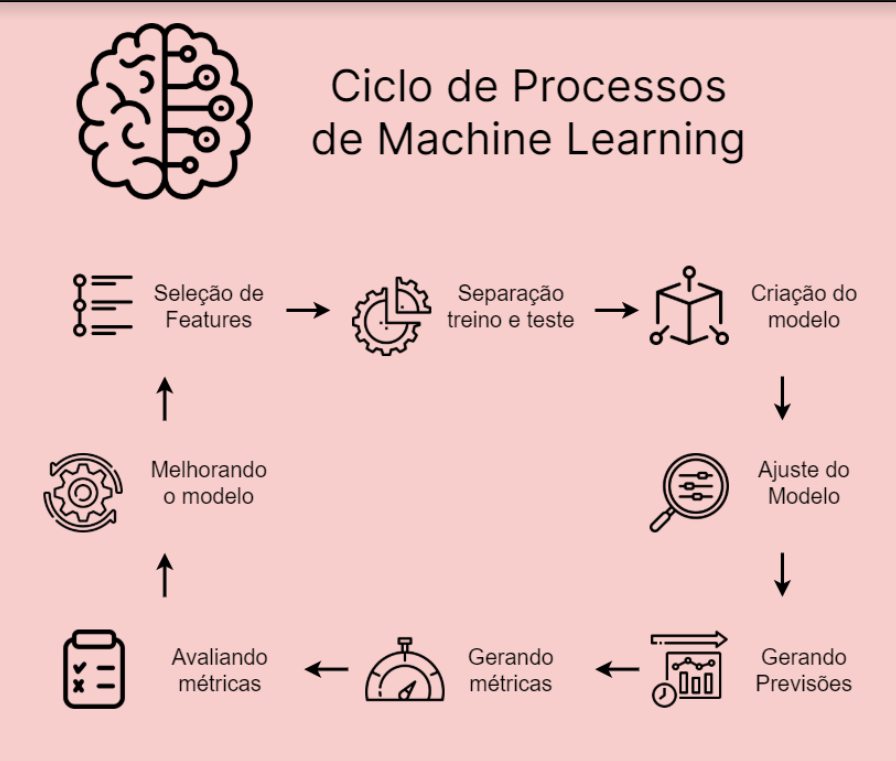